In [301]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import sys
from sklearn.datasets import load_boston, load_iris
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import random
np.random.seed(42)
%matplotlib inline

In [302]:
sys.path.append("../auto_impute/")

In [303]:
from csv_reader import CSVReader
from dp import DP
from sg import SingleGaussian
from gmm import GMM
from mi import MeanImpute

Generate plots of MSE and LL vs % missing (MCAR) for the DP, SG, MI, and GMM on Iris and Boston Housing

In [313]:
def run_model_on_dataset(data_loader, model_constructor, model_params={}, normalise=False):
    # load dataset
    X, _ = data_loader(return_X_y=True)
    rmses = np.zeros(9)
    lls = np.zeros_like(rmses)
    
    for i in range(1, 10):
        # randomly remove a % of the dataset
        mask = np.random.rand(*X.shape) <= i/100 + 0.9 
        masked_X = ma.masked_array(X, mask)
        if normalise:
            mean = ma.mean(masked_X, axis=0)
            std = ma.std(masked_X, axis=0)
            masked_X = (masked_X - mean)/std
#         model = model_constructor(masked_X,m0 = ma.mean(masked_X, axis=0),**model_params)
        model = model_constructor(masked_X,**model_params)
        if hasattr(model, 'fit'):
            model.fit(max_iters=100, ϵ=0.01)
            
        imputed_X = model.ml_imputation()
        if normalise:
            imputed_X = imputed_X*std + mean
            
        rmses[i-1] = np.sqrt(np.mean(np.power(X - imputed_X, 2)))
        
        ll = model.test_ll(X)
        lls[i-1] = np.mean(ll[mask])
        
    return rmses, lls       

In [310]:
r, l = run_model_on_dataset(load_iris, SingleGaussian, {"verbose": True}, normalise=True)

Fitting single gaussian using EM:
Starting Avg LL: -0.918939
Iter: 0			Avg LL: 0.260517
Fitting single gaussian using EM:
Starting Avg LL: -0.918939
Iter: 0			Avg LL: 0.476419
Fitting single gaussian using EM:
Starting Avg LL: -0.918939
Iter: 0			Avg LL: 0.393162
Fitting single gaussian using EM:
Starting Avg LL: -0.918939
Iter: 0			Avg LL: 0.298254
Fitting single gaussian using EM:
Starting Avg LL: -0.918939
Iter: 0			Avg LL: 0.587057
Fitting single gaussian using EM:
Starting Avg LL: -0.918939
Iter: 0			Avg LL: 0.652095
../auto_impute/sg.py:177: RuntimeWarning: divide by zero encountered in log
  lls[n, d] = np.log(stats.multivariate_normal.pdf(x_row[d], mean=μ, cov=σ2))
Fitting single gaussian using EM:
Starting Avg LL: -0.918939
Iter: 0			Avg LL: 0.778480
Fitting single gaussian using EM:
Starting Avg LL: -0.918939
Iter: 0			Avg LL: 1.017006
Fitting single gaussian using EM:
Starting Avg LL: -0.918939
Iter: 0			Avg LL: 1.139120


In [311]:
# SG on iris
# repeat the experiment 10 times to get a mean and variance
rmses = np.zeros(shape=(10, 9))
lls = np.zeros_like(rmses)

for i in range(10):
    print(i)
    r, l = run_model_on_dataset(load_iris, SingleGaussian, {"independent_vars":True}, normalise=True)
    
    rmses[i, :] = r
    lls[i, :] = l

0


../auto_impute/sg.py:177: RuntimeWarning: divide by zero encountered in log
  lls[n, d] = np.log(stats.multivariate_normal.pdf(x_row[d], mean=μ, cov=σ2))


1
2
3
4
5
6
7
8
9


In [312]:
print(np.mean(rmses, axis=0))
print(np.std(rmses, axis=0))
print(np.mean(lls, axis=0))
print(np.std(lls, axis=0))

[1.05521301 1.05999486 1.09217855 1.13643642 1.16460574 1.17357774
 1.16130691 1.16698382 1.22735527]
[0.03795784 0.02591548 0.0534293  0.12011259 0.13632789 0.10923505
 0.10933556 0.27863124 0.31592331]
[-89.23349774 -98.35424152         -inf         -inf         -inf
         -inf         -inf         -inf         -inf]
[18.70107482 23.30098573         nan         nan         nan         nan
         nan         nan         nan]


/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[-1.26865567 -1.25435851 -1.2874415  -1.30447339 -1.44070357 -1.59017655
 -1.92969948 -2.4495219  -5.10813152]
[0.12616627 0.07193603 0.0592975  0.06399185 0.07411055 0.12715965
 0.27084744 0.26129236 1.33725509]


In [21]:
# np.savetxt(X=np.stack([np.arange(1,10)*10, np.mean(rmses, axis=0), np.std(rmses, axis=0), np.mean(lls, axis=0), np.std(lls, axis=0)], axis=1),
#            delimiter=",",header="x,rm,rs,lm,ls",fname="msg_iris_test.csv", fmt="%.7g", comments='')

In [314]:
# DP on iris
# repeat the experiment 10 times to get a mean and variance
rmses = np.zeros(shape=(10, 9))
lls = np.zeros_like(rmses)

for i in range(10):
    print(i)
    r, l = run_model_on_dataset(load_iris, DP)
    
    rmses[i, :] = r
    lls[i, :] = l

0
1
2
3
4
5
6
7
8
9


In [315]:
print(np.mean(rmses, axis=0))
print(np.std(rmses, axis=0))
print(np.mean(lls, axis=0))
print(np.std(lls, axis=0))

[1.46651981 1.40225794 1.55158431 1.53468595 1.6070432  1.65328043
 1.46742055 1.7902036  2.1486754 ]
[0.18986742 0.20765199 0.19533167 0.2016822  0.13377399 0.24002533
 0.1907099  0.53995622 0.7691125 ]
[ -8.23169162  -8.45429393  -8.61760712  -8.79051254  -9.12664571
  -9.29220434  -9.6982336   -9.927023   -10.16584649]
[0.31885606 0.47061703 0.4695374  0.22476669 0.46594952 0.2296294
 0.38693494 0.24895885 0.15273689]


In [8]:
# np.savetxt(X=np.stack([np.arange(1,10)*10, np.mean(rmses, axis=0), np.std(rmses, axis=0), np.mean(lls, axis=0), np.std(lls, axis=0)], axis=1),
#            delimiter=",",header="x,rm,rs,lm,ls",fname="dp_iris_test.csv", fmt="%.7g", comments='')

In [316]:
# MI on iris
# repeat the experiment 10 times to get a mean and variance
rmses = np.zeros(shape=(10, 9))
lls = np.zeros_like(rmses)

for i in range(10):
    print(i)
    r, l = run_model_on_dataset(load_iris, MeanImpute)
    
    rmses[i, :] = r
    lls[i, :] = l

0


../auto_impute/mi.py:46: RuntimeWarning: divide by zero encountered in log
  lls[n, d] = np.log(stats.norm.pdf(test_data[n, d], loc=self.μ[d], scale=1e-1))


1
2
3
4
5
6
7
8
9


In [317]:
print(np.mean(rmses, axis=0))
print(np.std(rmses, axis=0))
print(np.mean(lls, axis=0))
print(np.std(lls, axis=0))

[1.04742309 1.06638577 1.06297386 1.09807811 1.07636648 1.21758709
 1.38125159 1.52266436 2.10407097]
[0.02036739 0.02925598 0.03824084 0.05188336 0.02184406 0.18959315
 0.58157755 0.67946716 0.78357585]
[        -inf         -inf -59.60487747         -inf         -inf
         -inf         -inf         -inf         -inf]
[       nan        nan 4.40940703        nan        nan        nan
        nan        nan        nan]


/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [7]:
# np.savetxt(X=np.stack([np.arange(1,10)*10, np.mean(rmses, axis=0), np.std(rmses, axis=0), np.mean(lls, axis=0), np.std(lls, axis=0)], axis=1),
#            delimiter=",",header="x,rm,rs,lm,ls",fname="mi_iris_test.csv", fmt="%.7g", comments='')

/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [318]:
# GMM on iris
# repeat the experiment 10 times to get a mean and variance
rmses = np.zeros(shape=(10, 9))
lls = np.zeros_like(rmses)

for i in range(10):
    print(i)
    r, l = run_model_on_dataset(load_iris, GMM, {"num_components":3}, normalise=True)
    
    rmses[i, :] = r
    lls[i, :] = l

0
1
2
3
4
5
6
7
8
9


In [319]:
print(ma.mean(ma.masked_array(rmses, rmses>1.5) ,axis=0).data)
print(ma.std(ma.masked_array(rmses, rmses>1.5) ,axis=0).data)

[1.09396677 1.04812134 1.13758931 1.12218869 1.14892942 1.2227487
 1.29383532 1.20334904 0.98031817]
[0.05833395 0.02909192 0.09164839 0.02764085 0.05476145 0.14451133
 0.14451134 0.09387772 0.1847068 ]


In [320]:
print(np.mean(rmses, axis=0))
print(np.std(rmses, axis=0))
print(np.mean(lls, axis=0))
print(np.std(lls, axis=0))

[4.664774   5.17197802 4.32149935 3.76664729 6.99950983 6.06283657
 9.26435701 3.38823209 1.40244645]
[ 3.68639907  5.46511713  4.69665465  2.24586564  6.42497498  8.5163565
 14.38668404  3.30975904  0.86348138]
[-3.24230437 -3.50704392 -3.21492124 -3.43290808 -3.29280913 -3.41256711
 -3.10477659 -3.76915605 -3.93632643]
[0.14650438 0.8862164  0.35415349 0.6257306  0.66023637 0.91407355
 0.28415775 0.95800294 1.63063742]


In [16]:
# np.savetxt(X=np.stack([np.arange(1,10)*10, ma.mean(ma.masked_array(rmses, rmses>1.5) ,axis=0).data,ma.std(ma.masked_array(rmses, rmses>1.5) ,axis=0).data, np.mean(lls, axis=0), np.std(lls, axis=0)], axis=1),
#            delimiter=",",header="x,rm,rs,lm,ls",fname="../../MphilACS-dissertation/evaluation/gmm3_f_iris_test.csv", fmt="%.7g", comments='')

Cool PCA example

In [398]:
from sklearn.preprocessing import StandardScaler

iris = load_iris()

pca = PCA(n_components=2)
cols = [2,3]

principalComponents = pca.fit_transform(X = iris.data[:,cols])

# to get how much variance was retained
print(pca.explained_variance_ratio_.sum())
print(pca.components_)

1.0
[[ 0.92154695  0.38826694]
 [-0.38826694  0.92154695]]


(-0.1, 2.6)

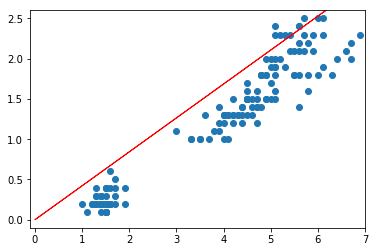

In [399]:
scale = np.sqrt(np.max(iris.data[:,cols[1]])**2 + np.max(iris.data[:,cols[0]])**2)
plt.arrow(0, 0, pca.components_[0,0]*scale, pca.components_[0,1]*scale,color = 'r')
plt.scatter(iris.data[:,cols[0]], iris.data[:,cols[1]])
plt.xlim([-0.1,np.max(iris.data[:,cols[0]]) + 0.1])
plt.ylim([-0.1,np.max(iris.data[:,cols[1]]) + 0.1])
# plt.arrow(0, 0, pca.components_[0,0]*scale, pca.components_[0,1]*-1*scale,color = 'r')

In [597]:
# mask = iris.data[:,2] >= 3
# mask = np.random.rand(*X.shape) <= 1/10
mask = np.stack([iris.data[:,cols[1]] >= 1.5, np.array([False]*iris.data.shape[0])], axis=1)
# mask = mask[:,[2,3]]
iris_complete_case = iris.data[~np.any(mask, axis=1)][:,cols]
print(iris_complete_case.shape)
iris_complete_case.shape
pca_cc = PCA(n_components=2)
pca_cc.fit_transform(X = iris_complete_case)
components_cc  = pca_cc.components_

(86, 2)


In [630]:
np.savetxt(X=iris_complete_case,
    delimiter=",",header="x,y",fname="../../MphilACS-dissertation/evaluation/iris_complete_case.csv", fmt="%.7g", comments='')

In [631]:
np.savetxt(X=iris.data[np.any(mask, axis=1)][:,cols],
    delimiter=",",header="x,y",fname="../../MphilACS-dissertation/evaluation/iris_maked.csv", fmt="%.7g", comments='')

In [633]:
print(components_cc[0,0]*10, components_cc[0,1]*10)
print(pca.components_[0,0]*10, pca.components_[0,1]*10)

9.402434670268558 3.4050289677669108
9.215469497911123 3.882669433916534


(-0.1, 2.6)

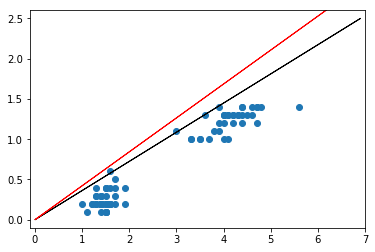

In [598]:
plt.scatter(iris_complete_case[:,0], iris_complete_case[:,1])
plt.arrow(0, 0, components_cc[0,0]*scale, components_cc[0,1]*scale,color = 'black')
plt.arrow(0, 0, pca.components_[0,0]*scale, pca.components_[0,1]*scale,color = 'r')
plt.xlim([-0.1,np.max(iris.data[:,cols[0]]) + 0.1])
plt.ylim([-0.1,np.max(iris.data[:,cols[1]]) + 0.1])

In [599]:
num_samples = 100
data = ma.masked_array(iris.data[:,cols], mask)

model = SingleGaussian(data=data, verbose=True, independent_vars=False, W0=np.eye(2)*100)
model.fit(ε=0)
repaird_datasets = model.sample(num_samples)
components = []

for i in range(num_smaples):
    pca_sg = PCA(n_components=2)
    pca_sg.fit_transform(X = repaird_datasets[i, :, :])
    components.append(pca_sg.components_)
    

Fitting single gaussian using EM:
Starting Avg LL: -3.221524
Iter: 0			Avg LL: -1.506546
Iter: 1			Avg LL: -1.313647
Iter: 2			Avg LL: -1.217870
Iter: 3			Avg LL: -1.175924
Iter: 4			Avg LL: -1.158962
Iter: 5			Avg LL: -1.152342
Iter: 6			Avg LL: -1.149796
Iter: 7			Avg LL: -1.148822
Iter: 8			Avg LL: -1.148450
Iter: 9			Avg LL: -1.148308
Iter: 10			Avg LL: -1.148254
Iter: 11			Avg LL: -1.148234
Iter: 12			Avg LL: -1.148226
Iter: 13			Avg LL: -1.148223
Iter: 14			Avg LL: -1.148222
Iter: 15			Avg LL: -1.148221
Iter: 16			Avg LL: -1.148221
Iter: 17			Avg LL: -1.148221
Iter: 18			Avg LL: -1.148221
Iter: 19			Avg LL: -1.148221
Iter: 20			Avg LL: -1.148221
Iter: 21			Avg LL: -1.148221
Iter: 22			Avg LL: -1.148221
Iter: 23			Avg LL: -1.148221
Iter: 24			Avg LL: -1.148221
Iter: 25			Avg LL: -1.148221
Iter: 26			Avg LL: -1.148221
Iter: 27			Avg LL: -1.148221
Iter: 28			Avg LL: -1.148221
Iter: 29			Avg LL: -1.148221
Iter: 30			Avg LL: -1.148221
Iter: 31			Avg LL: -1.148221
Iter: 32			Avg LL: -1

In [600]:
np.all(repaird_datasets[0,:,:] == repaird_datasets[1,:,:])

False

(-0.1, 2.6)

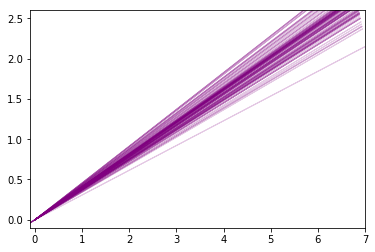

In [601]:
for i in range(num_samples):
    plt.arrow(0, 0, components[i][0,0]*scale, components[i][0,1]*scale,color = 'purple', alpha=0.2)
plt.xlim([-0.1,np.max(iris.data[:,cols[0]]) + 0.1])
plt.ylim([-0.1,np.max(iris.data[:,cols[1]]) + 0.1])

(-0.1, 2.6)

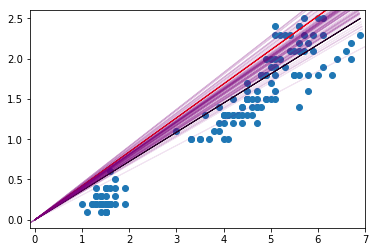

In [602]:
plt.scatter(iris.data[:,cols[0]], iris.data[:,cols[1]])
# scale_cc = np.sqrt(pca_cc.mean_[0]**2 + pca_cc.mean_[1]**2)
plt.arrow(0, 0, pca.components_[0,0]*scale, pca.components_[0,1]*scale,color = 'r')
plt.arrow(0, 0, pca_cc.components_[0,0]*scale, pca_cc.components_[0,1]*scale,color = 'black')
for i in range(num_samples):
    plt.arrow(0, 0, components[i][0,0]*scale, components[i][0,1]*scale,color = 'purple', alpha=0.1)
plt.xlim([-0.1,np.max(iris.data[:,cols[0]]) + 0.1])
plt.ylim([-0.1,np.max(iris.data[:,cols[1]]) + 0.1])
# plt.arrow(0, 0, pca.components_[1,0]*pca.explained_variance_[1], pca.components_[1,1]*pca.explained_variance_[1],color = 'r',alpha = 0.5)

In [624]:
temp = np.hstack([np.zeros(shape=(100,2)), np.abs(np.array(components)[:, 0, :])]).reshape(200, 2)
temp

array([[0.        , 0.        ],
       [0.93669336, 0.35015075],
       [0.        , 0.        ],
       [0.92486384, 0.3802984 ],
       [0.        , 0.        ],
       [0.93072086, 0.36573033],
       [0.        , 0.        ],
       [0.93680651, 0.34984792],
       [0.        , 0.        ],
       [0.91710441, 0.39864708],
       [0.        , 0.        ],
       [0.92638217, 0.37658476],
       [0.        , 0.        ],
       [0.92969515, 0.36832992],
       [0.        , 0.        ],
       [0.93203411, 0.36237057],
       [0.        , 0.        ],
       [0.9382055 , 0.34607866],
       [0.        , 0.        ],
       [0.93076706, 0.36561273],
       [0.        , 0.        ],
       [0.92791632, 0.37278854],
       [0.        , 0.        ],
       [0.92637672, 0.37659816],
       [0.        , 0.        ],
       [0.92695044, 0.37518379],
       [0.        , 0.        ],
       [0.92635879, 0.37664225],
       [0.        , 0.        ],
       [0.93728735, 0.34855763],
       [0.

In [626]:
temp = np.zeros(shape=(100,4))
temp[:, [2,3]] = np.array(components)[:, 0, :]
temp

array([[ 0.        ,  0.        ,  0.93669336,  0.35015075],
       [ 0.        ,  0.        ,  0.92486384,  0.3802984 ],
       [ 0.        ,  0.        ,  0.93072086,  0.36573033],
       [ 0.        ,  0.        ,  0.93680651,  0.34984792],
       [ 0.        ,  0.        ,  0.91710441,  0.39864708],
       [ 0.        ,  0.        ,  0.92638217,  0.37658476],
       [ 0.        ,  0.        ,  0.92969515,  0.36832992],
       [ 0.        ,  0.        , -0.93203411, -0.36237057],
       [ 0.        ,  0.        ,  0.9382055 ,  0.34607866],
       [ 0.        ,  0.        ,  0.93076706,  0.36561273],
       [ 0.        ,  0.        ,  0.92791632,  0.37278854],
       [ 0.        ,  0.        ,  0.92637672,  0.37659816],
       [ 0.        ,  0.        ,  0.92695044,  0.37518379],
       [ 0.        ,  0.        ,  0.92635879,  0.37664225],
       [ 0.        ,  0.        , -0.93728735, -0.34855763],
       [ 0.        ,  0.        ,  0.92045226,  0.39085501],
       [ 0.        ,  0.

In [629]:
# np.savetxt(X=np.abs(temp)*10,
#     delimiter=",",header="x,y,u,v",fname="pca.csv", fmt="%.7g", comments='')

In [18]:
X, _ = load_boston(return_X_y=True)
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10


In [19]:
tmp = X[np.random.choice(X.shape[0], 5, replace=False)]
pd.DataFrame(tmp)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,9.32909,0.0,18.10,0.0,0.7130,6.185,98.7,2.2616,24.0,666.0,20.2,396.90,18.13
1,0.01951,17.5,1.38,0.0,0.4161,7.104,59.5,9.2229,3.0,216.0,18.6,393.24,8.05
2,9.33889,0.0,18.10,0.0,0.6790,6.380,95.6,1.9682,24.0,666.0,20.2,60.72,24.08
3,0.62976,0.0,8.14,0.0,0.5380,5.949,61.8,4.7075,4.0,307.0,21.0,396.90,8.26
4,0.27957,0.0,9.69,0.0,0.5850,5.926,42.6,2.3817,6.0,391.0,19.2,396.90,13.59


In [20]:
np.savetxt(X=tmp, delimiter=" & ",fname=sys.stdout, fmt="%.9g", comments='')

9.32909 & 0 & 18.1 & 0 & 0.713 & 6.185 & 98.7 & 2.2616 & 24 & 666 & 20.2 & 396.9 & 18.13
0.01951 & 17.5 & 1.38 & 0 & 0.4161 & 7.104 & 59.5 & 9.2229 & 3 & 216 & 18.6 & 393.24 & 8.05
9.33889 & 0 & 18.1 & 0 & 0.679 & 6.38 & 95.6 & 1.9682 & 24 & 666 & 20.2 & 60.72 & 24.08
0.62976 & 0 & 8.14 & 0 & 0.538 & 5.949 & 61.8 & 4.7075 & 4 & 307 & 21 & 396.9 & 8.26
0.27957 & 0 & 9.69 & 0 & 0.585 & 5.926 & 42.6 & 2.3817 & 6 & 391 & 19.2 & 396.9 & 13.59


(array([471.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  35.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

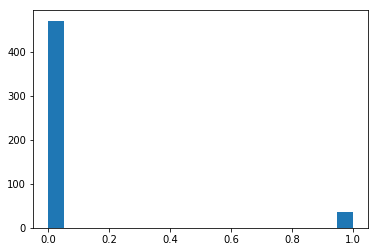

In [22]:
plt.hist(X[:,3], bins=20)

In [23]:
471/35

13.457142857142857

Generate MCAR, MAR, and NMAR datasets for testing

In [221]:
X, _ = load_boston(return_X_y=True)

In [27]:
def generate_MCAR(percentage, data):
    mask = np.random.rand(*X.shape) <= i/100
    missing_data = data.copy()
    missing_data[mask] = np.nan
    
    return missing_data

In [177]:
def generate_MAR(percentage, data):
    N, D = data.shape
    missing_data = data.copy()
    
    # randomly choose floor(D/5) columns as controlling
    rate = np.floor(D/5)
    control = random.sample(set(range(D)), int(rate))
    non_control = list(set(range(D)) - set(control))
    
    sums = np.sum(data[:, control], axis=1)
    for n in np.argsort(sums)[0:int(1/(1 - rate/D)*np.sqrt(percentage/100)*N)]:            
        
        for d in non_control:
            if np.random.rand(1) <= np.sqrt(percentage/100):
                missing_data[n, d] = np.nan
                    
    return missing_data

In [196]:
def generate_NMAR(percentage, data):
    N, D = data.shape
    missing_data = data.copy()
    
    # randomly choose floor(D/5) columns as controlling
    rate = np.floor(D*np.sqrt(percentage/100))
    control = random.sample(set(range(D)), int(rate))
    
    for d in control:
        
        for n in np.argsort(data[:, d])[0:int(np.sqrt(percentage/100)*N)]:
            missing_data[n, d] = np.nan
            
    return missing_data

In [216]:
for dataset, loader in [("boston", load_boston), ("iris", load_iris)]:
    X, _ = loader(return_X_y=True)
    for mtype, fun in [("NMAR", generate_NMAR), ("MAR", generate_MAR), ("MCAR", generate_MCAR)]:
        for perc in [10, 20, 30, 40, 50]:
            for i in range(10):
                np.savetxt(X=fun(perc, X), delimiter=",",fname="../data/report/%s_%s_%s_%s.csv" % (dataset, perc, mtype, i), fmt="%.9g")

In [257]:
np.loadtxt(fname="../data/report/boston_10_NMAR_1_mf.csv",delimiter=",").shape

(506, 13)

In [259]:
for dataset, loader in [("boston", load_boston), ("iris", load_iris)]:
    X, _ = loader(return_X_y=True)
    for mtype in ["NMAR", "MAR", "MCAR"]:
        to_write = []
        for perc in [10, 20, 30, 40, 50]:
            rmses = []
            for i in range(10):
                fname = "../data/report/%s_%s_%s_%s_mf.csv" % (dataset, perc, mtype, i)
                test = np.loadtxt(fname=fname,delimiter=",")
                rmses.append(np.sqrt(np.mean((test - X)**2)))
            
            mean_rmse = np.mean(rmses)
            std_rmse = np.std(rmses)
            to_write.append([perc, mean_rmse, std_rmse])
            
        to_write = np.array(to_write)
        np.savetxt(X=to_write, header="p,m,s", comments="", delimiter=",",
                   fname="../../MphilACS-dissertation/evaluation/mf_%s_%s.csv" % (dataset, mtype), fmt="%.9g")

In [296]:
def run_GMM_on_file(fname, normalise=True):
    # load dataset
    X = np.loadtxt(fname=fname,delimiter=",")
    mask = np.isnan(X)
    masked_X = ma.masked_array(X, mask)
    if normalise:
        mean = ma.mean(masked_X, axis=0)
        std = ma.std(masked_X, axis=0)
        masked_X = (masked_X - mean)/std
            
    model = GMM(masked_X,num_components=3, verbose=True, independent_vars=False, W0=np.eye(X.shape[1]))
    if hasattr(model, 'fit'):
            model.fit(max_iters=100, ϵ=0.01)
            
    imputed_X = model.ml_imputation()
    if normalise:
        imputed_X = imputed_X*std + mean
        
    return imputed_X 

In [297]:
foo = run_GMM_on_file("../data/report/boston_10_NMAR_1.csv")

Fitting GMM using EM algorithm (MAP estimate):
../auto_impute/gmm.py:252: RuntimeWarning: divide by zero encountered in log
  self.lls = np.log(self.lls)
Iter: 0			Avg LL: 1.053510
Iter: 1			Avg LL: 1.363387


In [300]:
for dataset, loader in [("iris", load_iris)]:
    X, _ = loader(return_X_y=True)
    for mtype in ["NMAR", "MAR", "MCAR"]:
        to_write = []
        for perc in [10, 20, 30, 40, 50]:
            print(perc)
            rmses = []
            for i in range(10):
                print(i)
                test = run_GMM_on_file("../data/report/%s_%s_%s_%s.csv" % (dataset, perc, mtype, i))
                rmses.append(np.sqrt(np.mean((test - X)**2)))
            
            mean_rmse = np.mean(rmses)
            std_rmse = np.std(rmses)
            to_write.append([perc, mean_rmse, std_rmse])
            
        to_write = np.array(to_write)
        np.savetxt(X=to_write, header="p,m,s", comments="", delimiter=",",
                   fname="../../MphilACS-dissertation/evaluation/gmm3depnormid_%s_%s.csv" % (dataset, mtype), fmt="%.9g")

10
0


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.482808
Iter: 1			Avg LL: 0.718320


1


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.958140


2


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.843013
Iter: 1			Avg LL: 0.915422
Iter: 2			Avg LL: 1.061232


3


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.029016
Iter: 1			Avg LL: 0.304438


4


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.641689


5


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.353518
Iter: 1			Avg LL: 0.362372
Iter: 2			Avg LL: 0.373474


6


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.576968
Iter: 1			Avg LL: 0.788956


7


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.945525
Iter: 1			Avg LL: 1.012755


8


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.329254
Iter: 1			Avg LL: 0.496734


9


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.490216


20
0


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.018584
Iter: 1			Avg LL: 0.327026


1


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.320564
Iter: 1			Avg LL: 0.542834
Iter: 2			Avg LL: 0.651472


2


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.122580
Iter: 1			Avg LL: 0.411001


3


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.725770


4


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.182047


5


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.859987


6


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.725608


7


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.652587
Iter: 1			Avg LL: 0.716324


8


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.443503
Iter: 1			Avg LL: 0.572140


9


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.800165
Iter: 1			Avg LL: 0.885669
Iter: 2			Avg LL: 1.296315


30
0


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.968755


1


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.433228


2


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.534355
Iter: 1			Avg LL: 0.663219


3


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.573520
Iter: 1			Avg LL: 0.654575


4


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.473661
Iter: 1			Avg LL: 0.624408
Iter: 2			Avg LL: 0.858784
Iter: 3			Avg LL: 0.870621
Iter: 4			Avg LL: 0.894493
Iter: 5			Avg LL: 0.928397
Iter: 6			Avg LL: 0.934369
Iter: 7			Avg LL: 0.948754
Iter: 8			Avg LL: 0.951805


5


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.489283
Iter: 1			Avg LL: 0.559108


6


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.714617
Iter: 1			Avg LL: 0.790679


7


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: -0.000554
Iter: 1			Avg LL: 0.512709


8


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.234117
Iter: 1			Avg LL: 0.541248


9


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.759189
Iter: 1			Avg LL: 1.018369


40
0


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.913658
Iter: 1			Avg LL: 0.938696


1


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.558164
Iter: 1			Avg LL: 0.827320
Iter: 2			Avg LL: 0.954634


2


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.636265


3


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.377570
Iter: 1			Avg LL: 1.150568


4


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.440676
Iter: 1			Avg LL: 0.858363


5


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.386567


6


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.498421


7


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.667118
Iter: 1			Avg LL: 0.690371
Iter: 2			Avg LL: 0.709127


8


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.283474
Iter: 1			Avg LL: 0.870862


9


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.196286
Iter: 1			Avg LL: 0.330962
Iter: 2			Avg LL: 0.411154


50
0


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.341335


1


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.341130
Iter: 1			Avg LL: 0.466563


2


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.365237
Iter: 1			Avg LL: 0.492612


3


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.459510


4


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.306546
Iter: 1			Avg LL: 1.097662


5


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.165113
Iter: 1			Avg LL: 0.260573
Iter: 2			Avg LL: 0.307608
Iter: 3			Avg LL: 0.353065
Iter: 4			Avg LL: 0.398177
Iter: 5			Avg LL: 0.427556
Iter: 6			Avg LL: 0.450149
Iter: 7			Avg LL: 0.464642
Iter: 8			Avg LL: 0.473218
Iter: 9			Avg LL: 0.476826


6


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.739689
Iter: 1			Avg LL: 1.044795


7


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.718581


8


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.300011
Iter: 1			Avg LL: 0.396998


9


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.690805
Iter: 1			Avg LL: 0.785635
Iter: 2			Avg LL: 1.056785
Iter: 3			Avg LL: 1.082620
Iter: 4			Avg LL: 1.140167
Iter: 5			Avg LL: 1.166434


10
0


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.193721
Iter: 1			Avg LL: 0.457751


1


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.604361


2


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.570514


3


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.831024
Iter: 1			Avg LL: 0.980647


4


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.907355


5


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.742867
Iter: 1			Avg LL: 0.879008
Iter: 2			Avg LL: 0.997528


6


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.497765


7


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 1.053919


8


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.778022


9


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.971710


20
0


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.447587
Iter: 1			Avg LL: 0.928075


1


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.041236
Iter: 1			Avg LL: 0.761621


2


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.592285


3


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.591695
Iter: 1			Avg LL: 0.861284


4


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.596328


5


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.121110
Iter: 1			Avg LL: 0.444818


6


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.368694
Iter: 1			Avg LL: 0.701669


7


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.729015


8


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.908537
Iter: 1			Avg LL: 0.978877


9


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.293016


30
0


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.440813


1


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.354180


2


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.582643
Iter: 1			Avg LL: 0.624629


3


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.535040


4


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.631530


5


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.260955


6


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.353418


7


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.283096
Iter: 1			Avg LL: 0.287365


8


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.526628


9


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.282765
Iter: 1			Avg LL: 0.919132


40
0


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.358548


1


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.549263


2


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.629937


3


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.505998
Iter: 1			Avg LL: 0.558971
Iter: 2			Avg LL: 0.701012


4


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.589359
Iter: 1			Avg LL: 0.670721


5


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.489585
Iter: 1			Avg LL: 0.540763


6


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.370016
Iter: 1			Avg LL: 0.562621


7


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.277670
Iter: 1			Avg LL: 0.496673


8


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.147117
Iter: 1			Avg LL: 0.408209
Iter: 2			Avg LL: 0.483171
Iter: 3			Avg LL: 0.515664


9


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: -0.016370
Iter: 1			Avg LL: 0.521889


50
0


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.220699


1


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.410839
Iter: 1			Avg LL: 0.516732


2


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.556607
Iter: 1			Avg LL: 0.604066


3


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.044816
Iter: 1			Avg LL: 0.601350


4


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.467744


5


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.464621


6


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.133136
Iter: 1			Avg LL: 0.697246


7


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.479619


8


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.255441
Iter: 1			Avg LL: 0.378502


9


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.325197
Iter: 1			Avg LL: 0.455561


10
0


Fitting GMM using EM algorithm (MAP estimate):


1


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.732217


2


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.329983


3


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.246549


4


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.743390


5


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.345625


6


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.542620
Iter: 1			Avg LL: 0.723660


7


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.302004


8


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.664995
Iter: 1			Avg LL: 0.919357


9


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.706635


20
0


Fitting GMM using EM algorithm (MAP estimate):


1


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.692843


2


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.910882
Iter: 1			Avg LL: 1.032534
Iter: 2			Avg LL: 1.052075


3


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 1.005737
Iter: 1			Avg LL: 1.212870


4


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.473056
Iter: 1			Avg LL: 0.667362


5


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.497306


6


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.972902


7


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.782280


8


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.866079
Iter: 1			Avg LL: 0.982188


9


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.386877


30
0


Fitting GMM using EM algorithm (MAP estimate):


1


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.831180


2


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.879450


3


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.454888
Iter: 1			Avg LL: 0.672249


4


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.454099
Iter: 1			Avg LL: 0.614666


5


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.842101


6


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.647600


7


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 1.100357
Iter: 1			Avg LL: 1.109323


8


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.775268


9


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.873524
Iter: 1			Avg LL: 1.001110


40
0


Fitting GMM using EM algorithm (MAP estimate):


1


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.709131


2


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.542863
Iter: 1			Avg LL: 0.589622


3


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.147917
Iter: 1			Avg LL: 0.162141
Iter: 2			Avg LL: 0.183862
Iter: 3			Avg LL: 0.185112


4


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.572169


5


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.650639
Iter: 1			Avg LL: 0.676212


6


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.822337


7


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.613584


8


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.338720
Iter: 1			Avg LL: 0.602685


9


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.741624


50
0


Fitting GMM using EM algorithm (MAP estimate):


1


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.556214


2


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.584238
Iter: 1			Avg LL: 1.231953


3


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.669375


4


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.872263


5


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.773134


6


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.439904


7


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.567864
Iter: 1			Avg LL: 0.657758


8


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.869778
Iter: 1			Avg LL: 0.931520


9


Fitting GMM using EM algorithm (MAP estimate):
Iter: 0			Avg LL: 0.742610
